In [9]:
import gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

def policy(state, Q1, Q2, epsilon):
    epsilon = 0.1
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2])  # 0: Stick, 1: Hit, 2: Double Down
    else:
        q_values = np.array([Q1[state][a] + Q2[state][a] for a in range(3)])
        return np.argmax(q_values)

def double_q_update(state, action, reward, next_state, done, Q1, Q2, alpha, gamma):
    if done:
        next_state_value = 0
    else:
        next_state_value = np.max(Q1[next_state] + Q2[next_state])
    
    if np.random.rand() < 0.5:
        Q1[state][action] += alpha * (reward + gamma * next_state_value - Q1[state][action])
    else:
        Q2[state][action] += alpha * (reward + gamma * next_state_value - Q2[state][action])

def handle_double_down(env, state, Q1, Q2, alpha, gamma):
    next_state, reward, done, _, _ = env.step(1)  # Take one hit
    if not done: 
        next_state, reward, done, _, _ = env.step(0)  # Then stand
    reward *= 2  # Double the reward
    return next_state, reward, done

def update_q_values(env, Q1, Q2, alpha, gamma,epsilon):
    state = env.reset()
    state = state[0]
    done = False
    while not done:
        action = policy(state, Q1, Q2,epsilon)
        if action == 2:  # Double down action
            next_state, reward, done = handle_double_down(env, state, Q1, Q2, alpha, gamma)
        else:
            next_state, reward, done, _, _ = env.step(action)
        double_q_update(state, action, reward, next_state, done, Q1, Q2, alpha, gamma)
        state = next_state

In [34]:
def prepare_data_for_heatmap(Q1, Q2):
    data = {
        'Player Sum': [],
        'Dealer Card': [],
        'Has Usable Ace': [],
        'Value': []
    }
    for key in Q1.keys():
        player_sum, dealer_card, usable_ace = key
        summed_values = np.array(Q1[key]) + np.array(Q2[key])
        best_action_value = max(summed_values)
        data['Player Sum'].append(player_sum)
        data['Dealer Card'].append(dealer_card)
        data['Has Usable Ace'].append('Yes' if usable_ace else 'No')
        data['Value'].append(best_action_value)
    return pd.DataFrame(data)

def plot_heatmap(df, title="Value Function"):
    if 'Has Usable Ace' in df.columns:
        df_yes = df[(df['Has Usable Ace'] == 'Yes') & (df['Player Sum'] >= 12)]
        df_no = df[(df['Has Usable Ace'] == 'No') & (df['Player Sum'] >= 4)]
        
        if not df_yes.empty:
            pivot_table_yes = df_yes.pivot(index="Player Sum", columns="Dealer Card", values="Value")
            plt.figure(figsize=(12, 9))
            sns.heatmap(pivot_table_yes, cmap="coolwarm", annot=True, fmt=".2f")
            plt.title(f"{title} (Usable Ace = Yes)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()

        if not df_no.empty:
            pivot_table_no = df_no.pivot(index="Player Sum", columns="Dealer Card", values="Value")
            plt.figure(figsize=(12, 9))
            sns.heatmap(pivot_table_no, cmap="coolwarm", annot=True, fmt=".2f")
            plt.title(f"{title} (Usable Ace = No)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()

def prepare_data_for_heatmap_action(Q1, Q2):
    data = {
        'Player Sum': [],
        'Dealer Card': [],
        'Has Usable Ace': [],
        'Value': []
    }
    for key in Q1.keys():
        player_sum, dealer_card, usable_ace = key
        summed_values = np.array(Q1[key]) + np.array(Q2[key])
        which_action_state = np.argmax(summed_values)
        data['Player Sum'].append(player_sum)
        data['Dealer Card'].append(dealer_card)
        data['Has Usable Ace'].append('Yes' if usable_ace else 'No')
        data['Value'].append(which_action_state)
    return pd.DataFrame(data)

def plot_heatmap_action(df, title="Optimal Action Plot"):
    if 'Has Usable Ace' in df.columns:
        df_yes = df[(df['Has Usable Ace'] == 'Yes') & (df['Player Sum'] >= 12)]
        df_no = df[(df['Has Usable Ace'] == 'No') & (df['Player Sum'] >= 4)]
        
        if not df_yes.empty:
            df_yes['Action'] = df_yes['Value'].replace({0: 'S', 1: 'H', 2: 'DD'})
            pivot_table_actions_yes = df_yes.pivot(index="Player Sum", columns="Dealer Card", values="Action")
            action_mapping = {'H': 0, 'S': 1, 'DD': 2}
            colormap_values_yes = pivot_table_actions_yes.replace(action_mapping)
            plt.figure(figsize=(12, 9))
            sns.heatmap(colormap_values_yes, cmap="coolwarm", annot=pivot_table_actions_yes, fmt="", cbar=False)
            plt.title(f"{title} (Usable Ace = Yes)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()

        if not df_no.empty:
            df_no['Action'] = df_no['Value'].replace({0: 'S', 1: 'H', 2: 'DD'})
            pivot_table_actions_no = df_no.pivot(index="Player Sum", columns="Dealer Card", values="Action")
            action_mapping = {'H': 0, 'S': 1, 'DD': 2}
            colormap_values_no = pivot_table_actions_no.replace(action_mapping)
            plt.figure(figsize=(12, 9))
            sns.heatmap(colormap_values_no, cmap="coolwarm", annot=pivot_table_actions_no, fmt="", cbar=False)
            plt.title(f"{title} (Usable Ace = No)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()



In [2]:
env = gym.make('Blackjack-v1')
gamma = 1.0  
alpha = 0.1  
num_episodes = 200000
epsilon=0.1

Q1 = {(player, dealer, ace): [0, 0, 0] for player in range(4, 22) for dealer in range(1, 11) for ace in [False, True]}
Q2 = {(player, dealer, ace): [0, 0, 0] for player in range(4, 22) for dealer in range(1, 11) for ace in [False, True]}

for i in range(num_episodes):
    update_q_values(env, Q1, Q2, alpha, gamma,epsilon)
    if (i%100000==0):
        print("episode no: ", i)

for state in list(Q1.keys())[-10:-1]:
    print(f"State: {state}, Q1: {Q1[state]}, Q2: {Q2[state]}")
    print("\n")

/home/dipit/anaconda3/envs/ds/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode no:  0
episode no:  100000
State: (21, 6, False), Q1: [0.9941063414277062, -0.46855900000000006, -1.0434062000000002], Q2: [0.9759806794567135, -0.7458134171671, -1.1390655800000002]


State: (21, 6, True), Q1: [0.9999588548188398, 0.4104780792198435, 0.635877846085142], Q2: [0.9999488095887905, 0.36298846267566554, 0.9064331555506686]


State: (21, 7, False), Q1: [0.9281319641182149, -0.7712320754503901, -1.3026431198000001], Q2: [0.8181709291233318, -0.8499053647030009, -1.37237880782]


State: (21, 7, True), Q1: [0.9042232071966853, 0.19911632243602823, 0.5535424653764462], Q2: [0.9999999999999996, 0.2670987464750438, 0.2640064700451421]


State: (21, 8, False), Q1: [0.9668237488678706, -0.6125795110000001, -1.7811620217369755], Q2: [0.8944969374190893, -0.68618940391, -1.37237880782]


State: (21, 8, True), Q1: [0.9996618527253374, 0.33575880384074996, 0.9121759509007801], Q2: [0.9745813417167098, 0.30218838034523515, 0.9217028826296318]


State: (21, 9, False), Q1: [0.9529

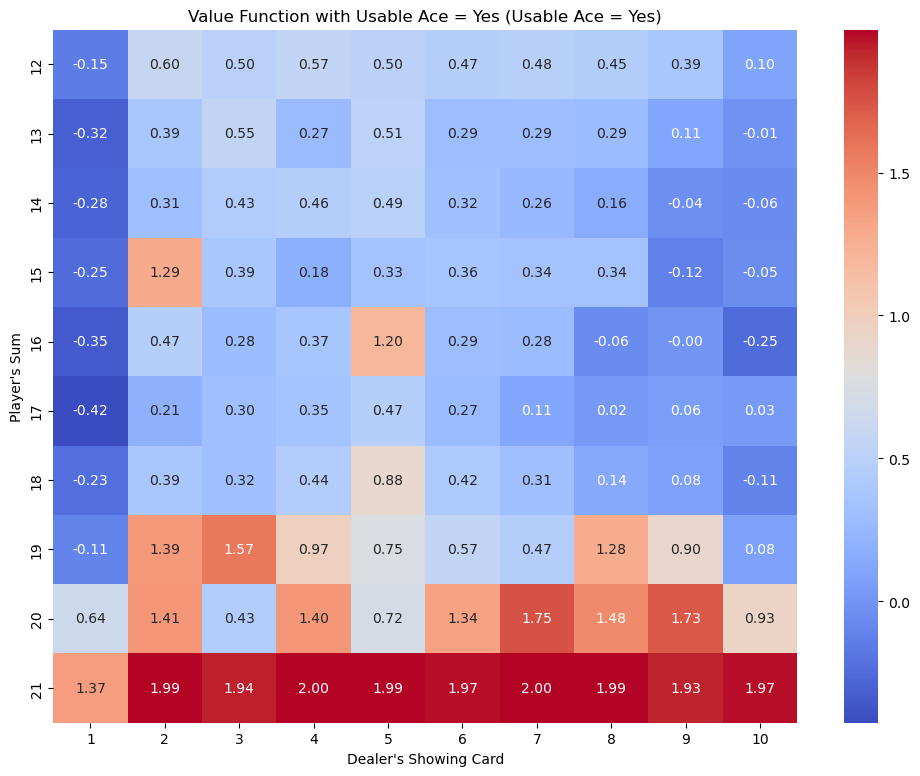

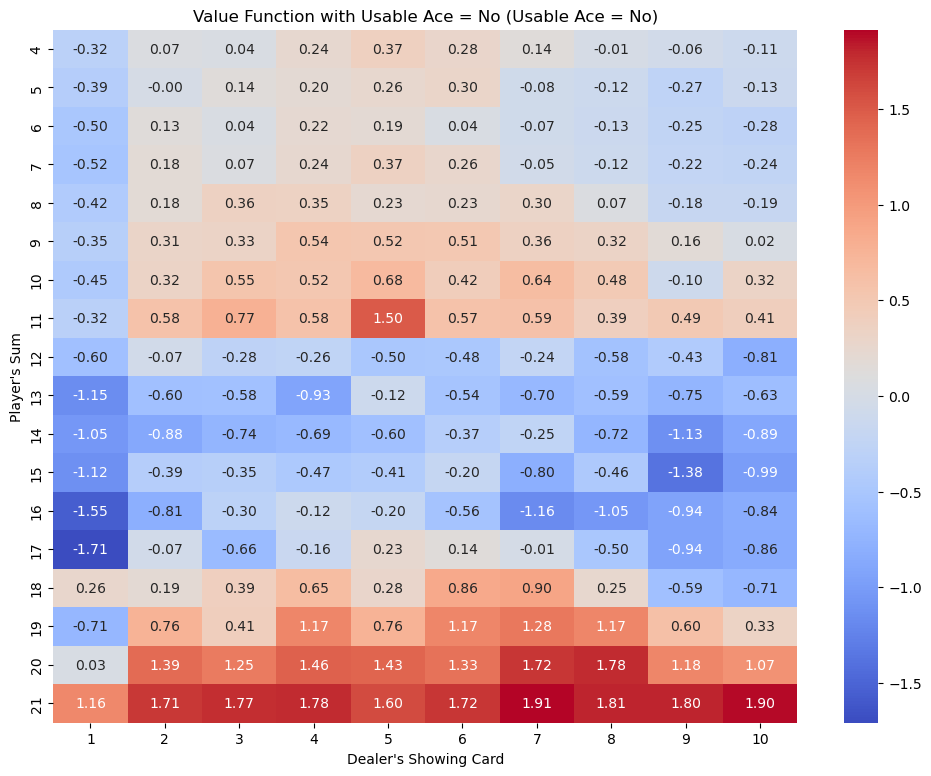

In [6]:
df = prepare_data_for_heatmap(Q1,Q2)

for has_ace in ['Yes', 'No']:
    filtered_df = df[df['Has Usable Ace'] == has_ace]
    plot_heatmap(filtered_df, f"Value Function with Usable Ace = {has_ace}")

/tmp/ipykernel_11799/19727433.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yes['Action'] = df_yes['Value'].replace({0: 'S', 1: 'H', 2: 'DD'})


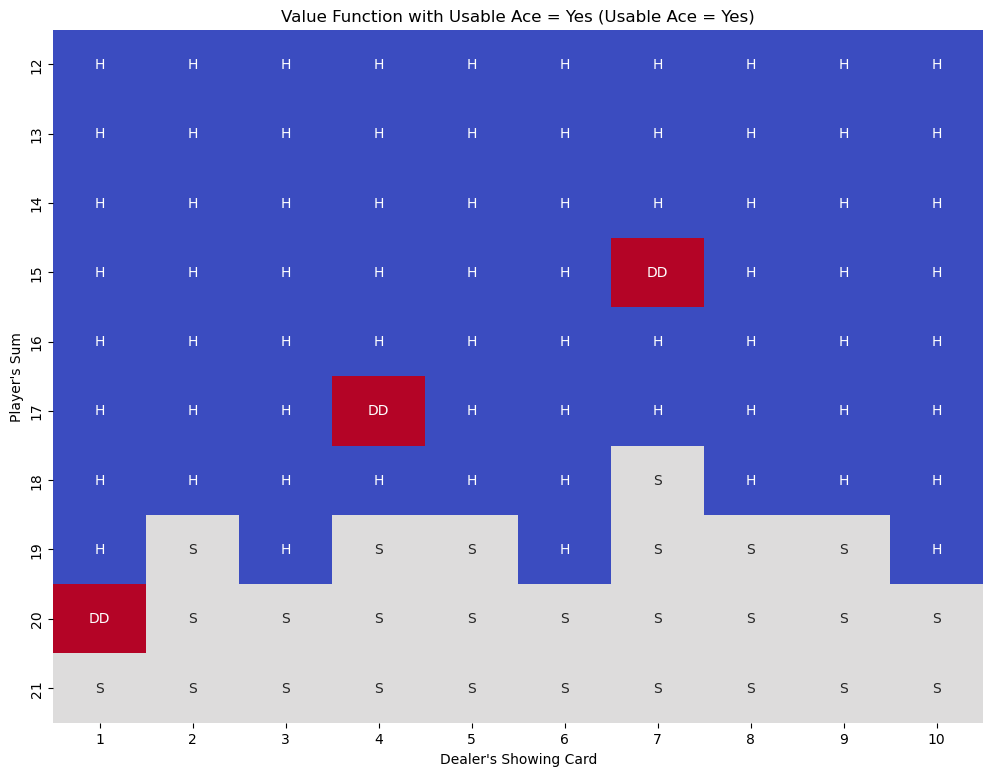

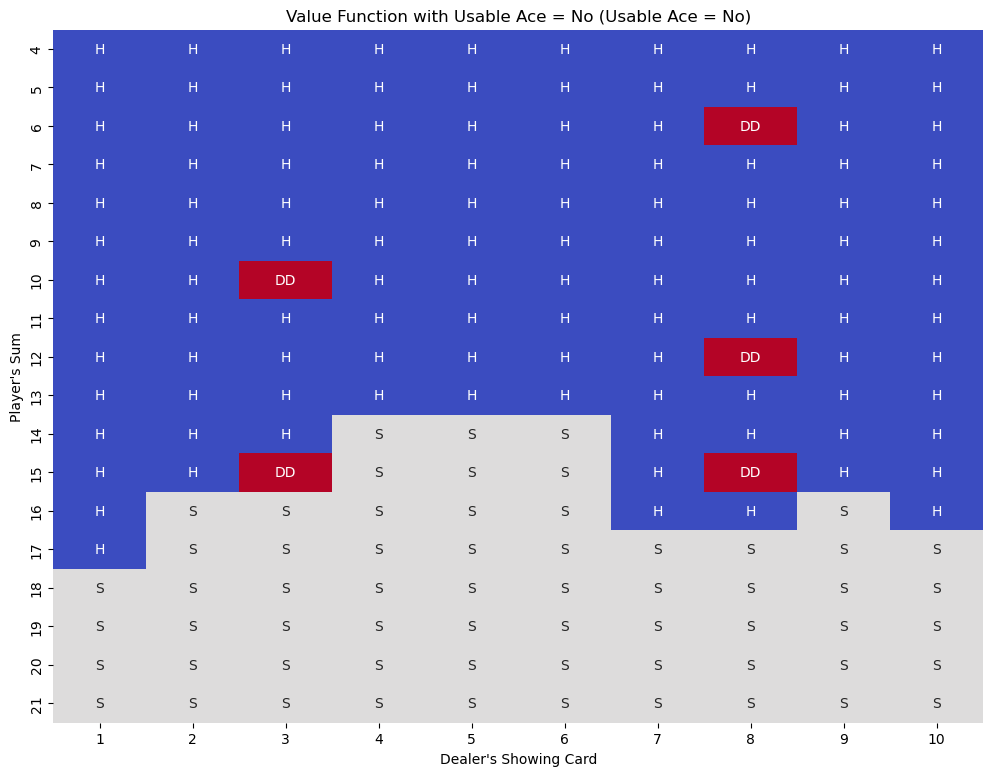

In [35]:

df = prepare_data_for_heatmap_action(Q1,Q2)

for has_ace in ['Yes', 'No']:
    filtered_df = df[df['Has Usable Ace'] == has_ace]
    plot_heatmap_action(filtered_df, f"Value Function with Usable Ace = {has_ace}")


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Player Sum      360 non-null    int64 
 1   Dealer Card     360 non-null    int64 
 2   Has Usable Ace  360 non-null    object
 3   Value           360 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 11.4+ KB
None


In [36]:
ace_matrix = np.zeros((10, 10))  # For player sum >= 12
non_ace_matrix = np.zeros((19, 10))  # For player sum >= 4

for index, row in df.iterrows():
    player_sum = row['Player Sum']
    dealer_card = row['Dealer Card']
    usable_ace = row['Has Usable Ace']
    value = row['Value']
    
    if usable_ace == 'Yes' and player_sum >= 12:
        ace_matrix[player_sum - 12, dealer_card - 1] = int(value)
    elif usable_ace == 'No' and player_sum >= 4:
        non_ace_matrix[player_sum - 4, dealer_card - 1] = int(value)

print("Ace Matrix:")
print(ace_matrix)
print("\nNon-Ace Matrix:")
print(non_ace_matrix)


Ace Matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 2. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Non-Ace Matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 2. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 2. 0. 0. 0. 1. 2. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
env.reset()
# Action mappings
ACTION_STICK = 0
ACTION_HIT = 1
ACTION_DOUBLE_DOWN = 2

# Function to get action from matrix
def get_action(player_sum, dealer_card, has_usable_ace):
    if has_usable_ace:
        return ace_matrix[player_sum - 12][dealer_card - 1]
    else:
        return non_ace_matrix[player_sum - 4][dealer_card - 1]

# Function to handle double down action
def handle_double_down(env, state):
    next_state, reward, done, _, _ = env.step(ACTION_HIT)  # Take one hit
    if not done:
        next_state, reward, done, _, _ = env.step(ACTION_STICK)  # Then stand
    reward *= 2  # Double the reward
    return next_state, reward, done

num_rounds = 100000
wins = 0
losses = 0
cumulative_winnings = 0

for _ in range(num_rounds):
    state, _ = env.reset()
    done = False
    reward = 0
    
    while not done:
        player_sum, dealer_card, has_usable_ace = state
        action = get_action(player_sum, dealer_card, has_usable_ace)
        if action==1.0:
            action=1
        elif action==2.0:
            action=2
        elif action==0.0:
            action=0
        if action == ACTION_DOUBLE_DOWN:
            next_state, reward, done = handle_double_down(env, state)
        else:
            next_state, reward, done, _, _ = env.step(action)
        
        state = next_state
    
    if reward > 0:
        wins += 1
    elif reward < 0:
        losses += 1
    
    cumulative_winnings += reward

# Print results
print("Number of wins:", wins)
print("Number of losses:", losses)
print("Cumulative winnings:", cumulative_winnings)
winperecentgae= wins/(wins+losses)*100
print(winperecentgae,"%")



Number of wins: 42441
Number of losses: 47916
Cumulative winnings: -6524.0
46.97035094126631 %


In [22]:
env = gym.make('Blackjack-v1')
num_episodes = 200000
gamma_values = [0.8, 0.85,0.95,0.9, 1.0]
alpha_values = [0.1, 0.15, 0.25,0.2, 0.3]
epsilon_values = [0.1,0.15,0.25, 0.2, 0.3]
param_combinations = list(itertools.product(gamma_values, alpha_values, epsilon_values))
results = pd.DataFrame(columns=['Gamma', 'Alpha', 'Epsilon', 'Wins', 'Losses', 'Cumulative Winnings','winperecentgae'])

for gamma, alpha, epsilon in param_combinations:
    Q1 = {(player, dealer, ace): [0, 0, 0] for player in range(4, 22) for dealer in range(1, 11) for ace in [False, True]}
    Q2 = {(player, dealer, ace): [0, 0, 0] for player in range(4, 22) for dealer in range(1, 11) for ace in [False, True]}
    cumulative_winnings = 0
    wins = 0
    losses = 0
    for i in range(num_episodes):
            update_q_values(env, Q1, Q2, alpha, gamma, epsilon)
    df = prepare_data_for_heatmap_action(Q1,Q2)
    ace_matrix = np.zeros((10, 10))  # For player sum >= 12
    non_ace_matrix = np.zeros((19, 10))  # For player sum >= 4
    
    for index, row in df.iterrows():
        player_sum = row['Player Sum']
        dealer_card = row['Dealer Card']
        usable_ace = row['Has Usable Ace']
        value = row['Value']
        
        if usable_ace == 'Yes' and player_sum >= 12:
            ace_matrix[player_sum - 12, dealer_card - 1] = int(value)
        elif usable_ace == 'No' and player_sum >= 4:
            non_ace_matrix[player_sum - 4, dealer_card - 1] = int(value)
    
    print("Ace Matrix:")
    print(ace_matrix)
    print("\nNon-Ace Matrix:")
    print(non_ace_matrix)
    env.reset()
    ACTION_STICK = 0
    ACTION_HIT = 1
    ACTION_DOUBLE_DOWN = 2
    
    def get_action_test(player_sum, dealer_card, has_usable_ace):
        if has_usable_ace:
            return ace_matrix[player_sum - 12][dealer_card - 1]
        else:
            return non_ace_matrix[player_sum - 4][dealer_card - 1]
    
    def handle_double_down_test(env, state):
        next_state, reward, done, _, _ = env.step(ACTION_HIT)  # Take one hit
        if not done:
            next_state, reward, done, _, _ = env.step(ACTION_STICK)  # Then stand
        reward *= 2  # Double the reward
        return next_state, reward, done
    
    # Play rounds
    num_rounds = 100000
    wins = 0
    losses = 0
    cumulative_winnings = 0
    
    for _ in range(num_rounds):
        state, _ = env.reset()
        done = False
        reward = 0
        
        while not done:
            player_sum, dealer_card, has_usable_ace = state
            action = get_action_test(player_sum, dealer_card, has_usable_ace)
            if action==1.0:
                action=1
            elif action==2.0:
                action=2
            elif action==0.0:
                action=0
            if action == ACTION_DOUBLE_DOWN:
                next_state, reward, done = handle_double_down_test(env, state)
            else:
                next_state, reward, done, _, _ = env.step(action)
            
            state = next_state
        
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        
        cumulative_winnings += reward
    
    print("Number of wins:", wins)
    print("Number of losses:", losses)
    print("Cumulative winnings:", cumulative_winnings)
    winperecentgae= wins/(num_rounds)*100
    print(winperecentgae,"%")
    results.loc[len(results.index)] = [gamma,alpha,epsilon,wins,losses,cumulative_winnings,winperecentgae] 





/home/dipit/anaconda3/envs/ds/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

In [29]:
results["winperecentgae"] = (results["Wins"]/100000)*100
print(results)

     Gamma  Alpha  Epsilon     Wins   Losses  Cumulative Winnings  \
3     0.80   0.10     0.20  42859.0  47866.0              -4864.0   
26    0.85   0.10     0.15  42719.0  47991.0              -5107.0   
44    0.85   0.20     0.30  42639.0  48035.0              -6160.0   
32    0.85   0.15     0.25  42508.0  47936.0              -4888.0   
102   1.00   0.10     0.25  42562.0  48057.0              -5386.0   
..     ...    ...      ...      ...      ...                  ...   
60    0.95   0.25     0.10  41013.0  49901.0             -10385.0   
122   1.00   0.30     0.25  40933.0  49936.0              -8820.0   
73    0.95   0.30     0.20  40850.0  50507.0              -9734.0   
85    0.90   0.25     0.10  40632.0  50665.0              -9731.0   
37    0.85   0.25     0.25  40500.0  50990.0             -10412.0   

     winperecentgae  
3            42.859  
26           42.719  
44           42.639  
32           42.508  
102          42.562  
..              ...  
60           41.0

In [30]:
sorted_results = results.sort_values(by='winperecentgae', ascending=False)

print("Top performing hyperparameters:")
print(sorted_results.head())

best_hyperparameters = sorted_results.iloc[0]
print("\nBest hyperparameters:")
print(best_hyperparameters)

Top performing hyperparameters:
     Gamma  Alpha  Epsilon     Wins   Losses  Cumulative Winnings  \
3     0.80   0.10     0.20  42859.0  47866.0              -4864.0   
0     0.80   0.10     0.10  42808.0  48492.0              -5647.0   
26    0.85   0.10     0.15  42719.0  47991.0              -5107.0   
109   1.00   0.15     0.30  42654.0  48578.0              -5790.0   
5     0.80   0.15     0.10  42647.0  49039.0              -6334.0   

     winperecentgae  
3            42.859  
0            42.808  
26           42.719  
109          42.654  
5            42.647  

Best hyperparameters:
Gamma                      0.800
Alpha                      0.100
Epsilon                    0.200
Wins                   42859.000
Losses                 47866.000
Cumulative Winnings    -4864.000
winperecentgae            42.859
Name: 3, dtype: float64


In [31]:
sorted_results = results.sort_values(by='Wins', ascending=False)

print("Top performing hyperparameters:")
print(sorted_results.head())

best_hyperparameters = sorted_results.iloc[0]
print("\nBest hyperparameters:")
print(best_hyperparameters)

Top performing hyperparameters:
     Gamma  Alpha  Epsilon     Wins   Losses  Cumulative Winnings  \
3     0.80   0.10     0.20  42859.0  47866.0              -4864.0   
0     0.80   0.10     0.10  42808.0  48492.0              -5647.0   
26    0.85   0.10     0.15  42719.0  47991.0              -5107.0   
109   1.00   0.15     0.30  42654.0  48578.0              -5790.0   
5     0.80   0.15     0.10  42647.0  49039.0              -6334.0   

     winperecentgae  
3            42.859  
0            42.808  
26           42.719  
109          42.654  
5            42.647  

Best hyperparameters:
Gamma                      0.800
Alpha                      0.100
Epsilon                    0.200
Wins                   42859.000
Losses                 47866.000
Cumulative Winnings    -4864.000
winperecentgae            42.859
Name: 3, dtype: float64


In [32]:
sorted_results = results.sort_values(by='Losses', ascending=True)

print("Top performing hyperparameters:")
print(sorted_results.head())

best_hyperparameters = sorted_results.iloc[0]
print("\nBest hyperparameters:")
print(best_hyperparameters)

Top performing hyperparameters:
     Gamma  Alpha  Epsilon     Wins   Losses  Cumulative Winnings  \
3     0.80   0.10     0.20  42859.0  47866.0              -4864.0   
32    0.85   0.15     0.25  42508.0  47936.0              -4888.0   
26    0.85   0.10     0.15  42719.0  47991.0              -5107.0   
44    0.85   0.20     0.30  42639.0  48035.0              -6160.0   
102   1.00   0.10     0.25  42562.0  48057.0              -5386.0   

     winperecentgae  
3            42.859  
32           42.508  
26           42.719  
44           42.639  
102          42.562  

Best hyperparameters:
Gamma                      0.800
Alpha                      0.100
Epsilon                    0.200
Wins                   42859.000
Losses                 47866.000
Cumulative Winnings    -4864.000
winperecentgae            42.859
Name: 3, dtype: float64


In [33]:
sorted_results = results.sort_values(by='winperecentgae', ascending=False)

print("Top performing hyperparameters:")
print(sorted_results.head())

best_hyperparameters = sorted_results.iloc[0]
print("\nBest hyperparameters:")
print(best_hyperparameters)

Top performing hyperparameters:
     Gamma  Alpha  Epsilon     Wins   Losses  Cumulative Winnings  \
3     0.80   0.10     0.20  42859.0  47866.0              -4864.0   
0     0.80   0.10     0.10  42808.0  48492.0              -5647.0   
26    0.85   0.10     0.15  42719.0  47991.0              -5107.0   
109   1.00   0.15     0.30  42654.0  48578.0              -5790.0   
5     0.80   0.15     0.10  42647.0  49039.0              -6334.0   

     winperecentgae  
3            42.859  
0            42.808  
26           42.719  
109          42.654  
5            42.647  

Best hyperparameters:
Gamma                      0.800
Alpha                      0.100
Epsilon                    0.200
Wins                   42859.000
Losses                 47866.000
Cumulative Winnings    -4864.000
winperecentgae            42.859
Name: 3, dtype: float64


In [28]:
results= sorted_results.copy()